# StroopActFlow -- Computational "Toy" Model

## Goal: Try to non-linear FC processes by estimating and extracting out the B0 term from multiple linear regression
### Idea: Using a simple dynamical model with a non-linearity (e.g., tanh, sigmoid, rectified linear unit) we can extract the bias term in the model for each node by estimating the B0 from multiple linear regression

#### Taku Ito
#### 01/26/2017

### Generate a simple model with no network structure with all excitatory connections


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import sys
import fc
% matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages


# 0.0 Set up network
## 0.1 Construct Network

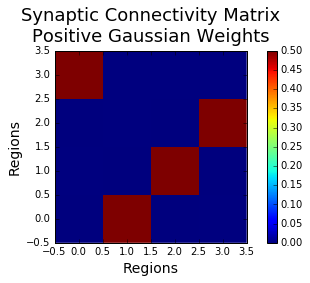

In [5]:
totalnodes = 4
Wee = np.ones((totalnodes,totalnodes))

################################
Wee = np.zeros((totalnodes,totalnodes))
for i in range(totalnodes):
    for j in range(totalnodes):
        if j-1 == i: 
            Wee[i,j] = 1.0
Wee[3,0] = 1
Gee = Wee
            

# Make sure self-connections exist
# np.fill_diagonal(Wee, 1)
# Find non-zero connections
# Gee = np.zeros((Wee.shape))
# # triu = np.triu_indices(totalnodes,k=0)
# connect_ind = np.where(Wee!=0)
# nconnects = len(connect_ind[0])
# # weights = np.random.lognormal(mean=1.0-np.log(0.2), sigma=1.0, size=(nconnects,))
# weights = np.random.normal(loc=1.0,scale=0.2, size=(nconnects,))
# weights = np.random.normal(loc=0,scale=1, size=(nconnects,))
# Gee[connect_ind] = weights

np.fill_diagonal(Gee,0)
Gee = Gee/np.sqrt(totalnodes)

# Gee = Wee 
# ind = np.triu_indices(4,k=1)
# Gee[ind] = 0 
fig = plt.figure()
plt.imshow(Gee, origin='lower', interpolation='none')#, vmin=0, vmax=20)
plt.colorbar()
plt.title('Synaptic Connectivity Matrix\nPositive Gaussian Weights', y=1.02, fontsize=18)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions',fontsize=14)
plt.tight_layout()



# 1.0 The model

$$ \frac{dx_{i}}{dt} \tau_{i} = -x_{i}(t) + \hspace{1 pt} \phi \bigg{(} g \sum_{j\neq i}^{N} \big{(} w_{ij} \hspace{1 pt} x_{j}(t) \big{)} + s  \hspace{2 pt} x_i(t) + b_{i}  + I_{i}(t) \bigg{)} $$

where $x_i$ is the activity of region $i$, $\tau_{i}$ is the time constant for region $i$, $s$ is the recurrent (local) coupling, $g$ is the global coupling parameter, $\phi$ is the bounded transfer function (in this scenario is the hyperbolic tangent), $W_{xy}$ is the synaptic connectivity matrix, and $I$ is the task-stimulation (if any).

## 1.1 Define simulation function and associated functions
* relu function
* hrf and convolution functions

### 1.1.1 - rectified linear unit function

In [822]:
def relu(x):
    """rectified linear unit"""
    ind = np.where(x<-1)[0]
    x[ind] = 0
#     ind = np.where(x>1)[0]
#     x[ind] = 0
    return x

### 1.1.2 - network model simulation

In [6]:
def networkModel(Tmax=100,dt=.1,g=3.0,s=1.0,tau=10.0,I=None, noise=None, bias=None, transfer='sigmoid'):
    """
    Tmax = 100      (1sec / 1000ms)
    dt = .1         (1ms)
    g = 3.0         Coupling 
    s = 1.0         Self connection
    tau = 1.0       Time constant 
    I = 0.0         Stimulation/Task
    
    
    """
    T = np.arange(0, Tmax, dt)

    # Select bias for each node
    if bias == None:
        bias = np.zeros((totalnodes,))
    
    # Select transfer function
    if transfer=='tanh':
        phi = lambda x: np.tanh(x)
    elif transfer=='sigmoid':
        phi = lambda x: 2/(1+np.exp(-2*x))
    elif transfer=='relu':
        def relu(x):
            """rectified linear unit"""
            ind = np.where(x<0)[0]
            x[ind] = 0
            return x
        phi = relu
    
    # External input (or task-evoked input) && noise input
    if I==None: I = np.zeros((totalnodes,len(T)))
    # Noise parameter
    if noise == None: 
        noise = np.zeros((totalnodes,len(T)))
    else: 
        noise = np.random.normal(size=(totalnodes,len(T)))/noise

    # Initial conditions and empty arrays
    Enodes = np.zeros((totalnodes,len(T)))
    # Initial conditions
    Einit = np.random.rand(totalnodes,)
    Enodes[:,0] = Einit

    spont_act = np.zeros((totalnodes,))
    for t in range(len(T)-1):

        ## Solve using Runge-Kutta Order 2 Method
        # With auto-correlation
        spont_act = (noise[:,t] + I[:,t])
        k1e = -Enodes[:,t] + phi(g*np.dot(Gee,Enodes[:,t]) + s*Enodes[:,t] + bias + spont_act)
        k1e = k1e/tau
        #   
        ave = Enodes[:,t] + k1e*dt
        #   
        # With auto-correlation
        spont_act = (noise[:,t+1] + I[:,t+1])
        k2e = -ave + phi(g*np.dot(Gee,ave) + s*ave + bias + spont_act)
        k2e = k2e/tau

        Enodes[:,t+1] = Enodes[:,t] + (.5*(k1e+k2e))*dt

    plt.figure()
    plt.imshow(Enodes[:,:100], origin='lower')
    plt.title('Activity')
    plt.ylabel('Regions')
    plt.xlabel('Time')
    plt.colorbar()

#     plt.figure()
#     plt.title('Activity of Sample Regions')
#     for i in range(4):
#         n = i
#         plt.plot(Enodes[n,:], label='Network' + str(i))
#     plt.legend(loc=(1.08,.5))
        
    return Enodes, bias

### 1.1.3 -  HRF function

In [7]:
from scipy.stats import gamma

def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6.0)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12.0)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

### 1.1.4 HRF convolution function

In [12]:
def convolveTimeseries(timeseries, samplingrate=1.0, TRLength=100):
    """
    Convolve the timeseries with a hemodynamic response function
    Also downsample the timeseries to an appropriate fMRI sampling rate
    Default sampling rate = 1.0 (10ms)
    Default TRLength = 100 (1 second)
    """

    simsample_rate=samplingrate
    simsample_times = np.arange(0, 30, simsample_rate, dtype=float)
    hrf_at_simsample = hrf(simsample_times)

    # Convolve simulated time series with HRF
    nregions = timeseries.shape[0]
    timeseries_convolved=np.ones(np.shape(timeseries),dtype=float)
    for region in range(nregions):
        convolved = np.convolve(timeseries[region,:], hrf_at_simsample)
        n_to_remove = len(hrf_at_simsample) - 1
        convolved = convolved[:-n_to_remove]
        timeseries_convolved[region,:]=convolved

    # Downsample fMRI time series
    TR=TRLength
    dt_rec=samplingrate
    n_skip_BOLD = int(TR/dt_rec)
    BOLD_rec = timeseries_convolved[:,::n_skip_BOLD]

    return BOLD_rec, timeseries_convolved

## 2.0 Simulate spontaneous activity with different transfer functions
* Simulations are run for 300 seconds
* Sampling rate of 10 ms
* global coupling paramter g = 1.0
* local coupling parameter s = 1.0
* Transfer functions: tanh, sigmoid, relu

#### Simulation parameters

In [16]:
# Simulation parameters
Tmaxrest = 30000 # 500 seconds
dt = 1.0 # Sampled @ 10ms

# Network parameters
g = 2.0
s = 1.0
noise = 1.0
tau = 1.0

# Set bias
bias = np.random.normal(size=(totalnodes,))
# bias = np.ones((totalnodes,))*-3
# bias = np.arange(totalnodes)
# bias = np.random.randint(-3,3,size=(totalnodes,))

## 2.1 Now model rest data with tanh function

/home/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


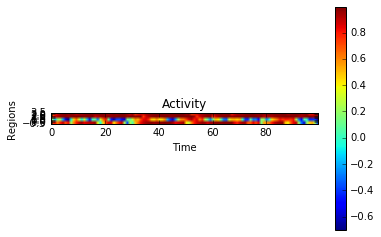

In [17]:
restdata, restbias = networkModel(Tmax=Tmaxrest,dt=dt,g=g,s=s,tau=tau,I=None, noise=noise, transfer='tanh', bias=bias)


### 2.1.1 Sample convolved resting-state timeseries

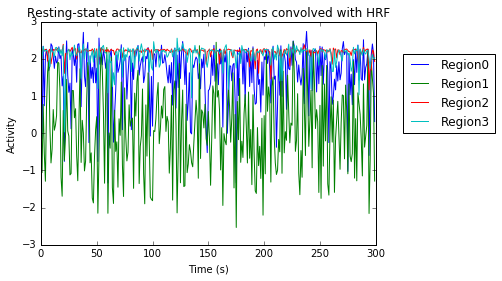

In [18]:
out1, out2 = convolveTimeseries(restdata, samplingrate=1.0, TRLength=100)
plt.figure()
plt.title('Resting-state activity of sample regions convolved with HRF')
for i in range(out1.shape[0]):
    n = i
    plt.plot(out1[n,:], label='Region' + str(i))
plt.legend(loc=(1.08,.5))
plt.ylabel('Activity')
plt.xlabel('Time (s)')

### 2.1.2 Perform MultRegConn FC and visualize matrix

#### 2.1.2.1 Compare pre-convolved timeseries B0 with restbias

Mean r-squared fit 0.201522858389
Std r-squared fit 0.0924245069994

Pearson-r of B0s pre-convolved with biases: 0.85719103062 ; p = 0.14280896938

Fit to intrinsic connectivity r = 0.445882321167 ; p = 0.0834458956794

B0s: [ 0.04716539 -0.48390855  0.67296388  0.22757501]
Biases: [ 0.98354995 -0.92982157  1.07860922  1.01197223]


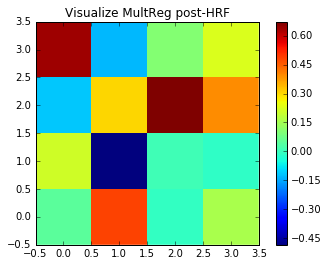

In [19]:
fc_multreg, rsquared = fc.tanhFC(restdata)
print 'Mean r-squared fit', np.mean(rsquared)
print 'Std r-squared fit', np.std(rsquared)
B0_multreg = np.diag(fc_multreg)
r, p = stats.pearsonr(restbias,B0_multreg)
print '\nPearson-r of B0s pre-convolved with biases:', r, '; p =' , p 
r, p = stats.pearsonr(np.reshape(fc_multreg,-1), np.reshape(Gee,-1))
print '\nFit to intrinsic connectivity r =', r, '; p =', p
print ''
print 'B0s:', B0_multreg
print 'Biases:', restbias

plt.imshow(fc_multreg,interpolation='none', origin='lower')
plt.colorbar()
plt.title('Visualize MultReg post-HRF')

#### 2.1.2.2 Compare HRF-convolved timeseries B0 with restbias

Mean r-squared fit 0.360867731531
Std r-squared fit 0.0859871196018

Pearson-r of B0s after HRF convolved with biases: 0.573009877712 ; p = 0.426990122288

Fit to intrinsic connectivity r = 0.415923586808 ; p = 0.109082706704

B0s: [-0.24495253 -0.30659879  0.62046415  0.07691074]
Biases: [ 0.98354995 -0.92982157  1.07860922  1.01197223]


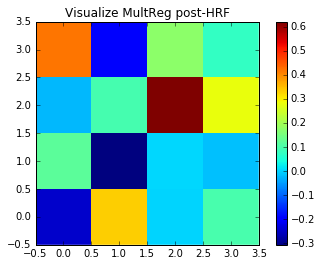

In [20]:
fc_multreg_hrf, rsquared_hrf = fc.tanhFC(out1)
print 'Mean r-squared fit', np.mean(rsquared_hrf)
print 'Std r-squared fit', np.std(rsquared_hrf)
B0_multreg_hrf = np.diag(fc_multreg_hrf)
r, p = stats.pearsonr(restbias,B0_multreg_hrf)
print '\nPearson-r of B0s after HRF convolved with biases:', r, '; p =', p 
r, p = stats.pearsonr(np.reshape(fc_multreg_hrf,-1), np.reshape(Gee,-1))
print '\nFit to intrinsic connectivity r =', r, '; p =', p
print ''
print 'B0s:', B0_multreg_hrf
print 'Biases:', restbias


plt.figure()
plt.imshow(fc_multreg_hrf, interpolation='none', origin='lower')
plt.colorbar()
plt.title('Visualize MultReg post-HRF')

## 2.3 Now model rest data with relu function

/home/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


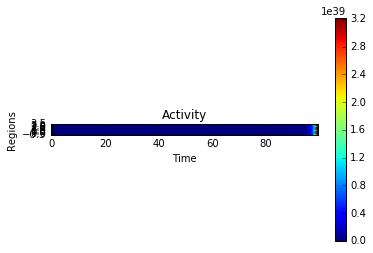

In [21]:
restdata, restbias = networkModel(Tmax=Tmaxrest,dt=dt,g=g,s=s,tau=tau,I=None, noise=noise, transfer='relu', bias=bias)


### 2.1.1 Sample convolved resting-state timeseries

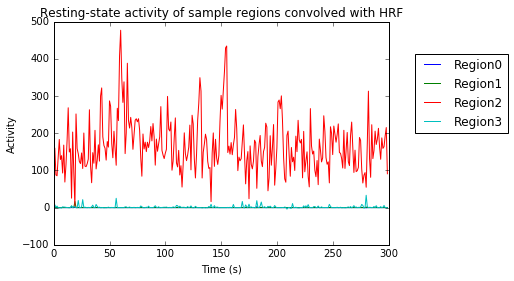

In [839]:
out1, out2 = convolveTimeseries(restdata, samplingrate=1.0, TRLength=100)
plt.figure()
plt.title('Resting-state activity of sample regions convolved with HRF')
for i in range(out1.shape[0]):
    n = i 
    plt.plot(out1[n,:], label='Region' + str(i))
plt.legend(loc=(1.08,.5))
plt.ylabel('Activity')
plt.xlabel('Time (s)')

### 2.1.2 Perform MultRegConn FC and visualize matrix

#### 2.1.2.1 Compare pre-convolved timeseries B0 with restbias

In [840]:
fc_multreg, rsquared = fc.multregressionconnectivity(restdata)
print 'Mean r-squared fit', np.mean(rsquared)
print 'Std r-squared fit', np.std(rsquared)
B0_multreg = np.diag(fc_multreg)
r, p = stats.pearsonr(restbias,B0_multreg)
print 'Pearson-r of B0s pre-convolved with biases:', r, '; p =' , p 

Mean r-squared fit 0.0717820411294
Std r-squared fit 0.0148146019748
Pearson-r of B0s pre-convolved with biases: -0.506682605369 ; p = 0.493317394631


In [841]:
print 'B0s:', B0_multreg
print 'Biases:', restbias

B0s: [  1.84324293e-02   5.82077772e-02   7.74530752e+01   1.36047191e+00]
Biases: [-0.0171418   0.88532109 -0.35122189 -0.24299308]


#### 2.1.2.2 Compare HRF-convolved timeseries B0 with restbias

In [ ]:
fc_multreg_hrf, rsquared_hrf = fc.multregressionconnectivity(out1)
print 'Mean r-squared fit', np.mean(rsquared_hrf)
print 'Std r-squared fit', np.std(rsquared_hrf)
plt.imshow(fc_multreg_hrf, interpolation='none', origin='lower')
plt.colorbar()
plt.title('Visualize MultReg post-HRF')

In [ ]:
B0_multreg_hrf = np.diag(fc_multreg_hrf)
r, p = stats.pearsonr(restbias,B0_multreg_hrf)
print 'Pearson-r of B0s after HRF convolved with biases:', r, '; p =', p 

In [ ]:
print 'B0s:', B0_multreg_hrf
print 'Biases:', restbias